## Imports

In [4]:
import numpy as np
import pandas as pd
import datetime
import math
import random
import sys

pd.options.display.max_columns = 50

In [5]:
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set(color_codes=True)

In [240]:
import pprint
from collections import defaultdict
import gensim
from gensim import corpora, models, similarities
# NLTK Stop words
from nltk.corpus import stopwords


## Functions

In [73]:
def set_labels(freq, ax,horz_shift=.2,vert_shift=1000,w="bold",fsize=10,c="b"):
    '''
    Function
    --------
    Set Frequency Labels on Bar Plot
    
    Parameters
    ----------
    freq : List of frequencies to plot for each bar
    ax : Axis to Plot Frequency Labels on
    horz_shift : Shift labels left/right
    vert_shift : Shift labels up/down
    w : "weight" -> Bold by defauly
    fsize : fontsize
    c : label color
    
    '''
    for i, v in enumerate(freq):
        ax.text(i-horz_shift,v+vert_shift, str(round(v,2)), weight = w,fontsize=fsize,color = c)

In [115]:
def process_corpus(text_corpus,min_words=3,max_percent=0.1):
    '''
    Function
    --------
    Process corpus by removing stopwords, lowercasing tokenized words,
        removing words ocurring in only 1 document or more than 10% of documents
    
    Parameters
    ----------
    text_corpus : Unprocessed Text Corpus
    
    Returns:
    -------
    processed_corpus : Processed Text Corpus
    ''' 
    # Remove Stop Words
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_',
                   'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 
                   'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 
                   'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])
    
    # Lowercase each document, split it by white space and filter out stopwords
    texts = ""
    texts = [[word for word in document.lower().split() if word not in stop_words] for document in text_corpus]
    
    # Count word frequencies
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
        
    # Only keep words that appear more than [min_words] times, 
    # are in less than [max_percent] of documents, and are alphabetical strings
    max_percent_calc = (int(len(text_corpus)*(max_percent)))
    
    processed_corpus = []
    for text in texts:
        token_list = []
        for token in text:
            if frequency[token] > min_words and frequency[token] < max_percent_calc and str.isalpha(token):
                token_list.append(token)
        processed_corpus.append(token_list)
    
    return processed_corpus

In [116]:
def create_index_from_corpus(processed_corpus):
    '''
    Function
    --------
    Trains model on processed corpus
    
    Also creates dictionary of words from processed corpus
    
    Parameters
    ----------
    processed_corpus : Processed Text Corpus
    
    Returns:
    -------
    
    ''' 
    dictionary = corpora.Dictionary(processed_corpus)
    features = (len(dictionary))
    
    # Convert documents into Bag of Words (BoW) format
    bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]
    
    # train the model
    tfidf = models.TfidfModel(bow_corpus)
    
    # Get cosine similarity of vectors of documents
    index = similarities.SparseMatrixSimilarity(tfidf[bow_corpus], num_features=features)
    
    return index, dictionary, tfidf

In [114]:
def find_similar_charities_category_score(train_df,test_df,column):
    '''
    Function
    --------
    Train Model on "corpus" column - composed of charity category, description, motto and state
    
    Parameters
    ----------
    train_df : DataFrame to Train LDA Model
    test_df : DataFrame to Test and Score Model
    
    Returns:
    -------
    top_3_sim : DataFrame of Top 3 Most Similar Charities
    '''
    total = 0
    category_counter = {1:0,2:0,3:0}
    document_min_words_cutoff = 200
    
    print("1. Processing Training Corpus")
    
    char_desc_trimmed = np.array(train_df[column])
    corpus = char_desc_trimmed
    
    processed_corpus = process_corpus(corpus)
    
    print("2. Creating Model from Training Corpus")
    index, dictionary, tfidf = create_index_from_corpus(processed_corpus)
    
    print("3. Starting Test Corpus Category Analysis\n")
    for ind, document in enumerate(test_df[column]):
        total +=1 
        if total % 500 == 0:
            print("Analyzed",total,"documents...")
        
        
        query_bow = dictionary.doc2bow(document.split())
        sims = index[tfidf[query_bow]]
        
        top_3_sim = dict()
        count = 3
        
        for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:
            
            if count > 0:
                top_3_sim[document_number] = score
            count -= 1
            
        category_count = 1
        
        for doc, score in top_3_sim.items():
            if train_df['category'].iloc[doc] == test_df['category'].iloc[ind]:
                category_counter[category_count] += 1
            category_count += 1
        
    
    first_rec_score = round((category_counter[1] / total)*100,2)
    second_rec_score = round((category_counter[2] / total)*100,2)
    third_rec_score = round((category_counter[3] / total)*100,2)
    
    print ("\nFirst Recommendation Score:", first_rec_score,"%")
    print ("Second Recommendation Score:", second_rec_score,"%")   
    print ("Third Recommendation Score:", third_rec_score,"%\n")
    
    print ("AVG Recommendation Score:", round((first_rec_score+second_rec_score+third_rec_score)/3,2),"%")
    
    return top_3_sim
    

In [93]:
def find_similar_charities_similar_score(train_df,test_df,column):
    '''
    Function
    --------
    Train Model on "corpus" column - composed of charity category, description, motto and state
    
    Parameters
    ----------
    train_df : DataFrame to Train LDA Model
    test_df : DataFrame to Test and Score Model
    
    Returns:
    -------
    top_3_sim : DataFrame of Top 3 Most Similar Charities
    '''
    total = 0
    category_counter = {1:0,2:0,3:0}
    document_min_words_cutoff = 200
    
    print("1. Processing Training Corpus")
    
    char_desc_trimmed = np.array(train_df[column])
    
    corpus = char_desc_trimmed
    processed_corpus = process_corpus(corpus)
    
    print("2. Creating Model from Training Corpus")
    index, dictionary, tfidf = create_index_from_corpus(processed_corpus)
    
    print("3. Starting Test Corpus Similarity Analysis\n")
    for ind, document in enumerate(test_df[column]):
        total +=1 
        if total % 500 == 0:
            print("Analyzed",total,"documents...")
        
        
        query_bow = dictionary.doc2bow(document.split())
        sims = index[tfidf[query_bow]]
        
        top_3_sim = dict()
        count = 3
        
        for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:
            
            if count > 0:
                top_3_sim[document_number] = score
            count -= 1
            
        category_count = 1
        
        for doc, score in top_3_sim.items():     
            category_counter[category_count] += score
            category_count +=1
    
    first_rec_score = round((category_counter[1] / total)*100,2)
    second_rec_score = round((category_counter[2] / total)*100,2)
    third_rec_score = round((category_counter[3] / total)*100,2)
    
    print ("\nFirst Recommendation Score:", first_rec_score,"%")
    print ("Second Recommendation Score:", second_rec_score,"%")   
    print ("Third Recommendation Score:", third_rec_score,"%\n")
    
    print ("AVG Recommendation Score:", round((first_rec_score+second_rec_score+third_rec_score)/3,2),"%")
    
    return top_3_sim
    

In [169]:
def find_similar_charities_from_search(train_df,search_text):
    '''
    Function
    --------
    Train Model on "corpus" column - composed of charity category, description, motto and state
    
    Parameters
    ----------
    train_df : DataFrame to Train LDA Model
    test_df : DataFrame to Test and Score Model
    
    Returns:
    -------
    top_3_sim : DataFrame of Top 3 Most Similar Charities
    '''
    total = 0
    category_counter = {1:0,2:0,3:0}
    document_min_words_cutoff = 200
    
    print("1. Processing Training Corpus")
    
    char_desc_trimmed = np.array(train_df['corpus'])
    
    corpus = char_desc_trimmed
    processed_corpus = process_corpus(corpus)
    
    print("2. Creating Model from Training Corpus")
    index, dictionary, tfidf = create_index_from_corpus(processed_corpus)
    
    print(dictionary.values())
    
    print("3. Starting Test Corpus Similarity Analysis\n")
    
    total +=1 
    if total % 500 == 0:
        print("Analyzed",total,"documents...")

    query_bow = dictionary.doc2bow(search_text.split())
    sims = index[tfidf[query_bow]]
    
    top_3_sim = dict()
    count = 3

    for document_number, score in sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[1:4]:

        if count > 0:
            top_3_sim[document_number] = score
        count -= 1

    category_count = 1

    for doc, score in top_3_sim.items():     
        category_counter[category_count] += score
        category_count +=1
    
    first_rec_score = round((category_counter[1] / total)*100,2)
    second_rec_score = round((category_counter[2] / total)*100,2)
    third_rec_score = round((category_counter[3] / total)*100,2)
    
    print ("\nFirst Recommendation Score:", first_rec_score,"%")
    print ("Second Recommendation Score:", second_rec_score,"%")   
    print ("Third Recommendation Score:", third_rec_score,"%\n")
    
    print ("AVG Recommendation Score:", round((first_rec_score+second_rec_score+third_rec_score)/3,2),"%")
    
    return top_3_sim
    

In [182]:
def create_sim_word_dict(text1, text2, dictionary):
    '''
    '''
    text1_array = text1.split()
    text2_array = text2.split()

    dict_list = []
    for i in range(len(dictionary)):
        dict_list.append(dictionary[i])
    dict_list = np.array(dict_list)

    similar_words = dict()

    for word in text1_array:
        if word in text2_array and word in dict_list:
            if word not in similar_words:
                similar_words[word] = 1
            else:
                similar_words[word] +=1

    return similar_words

In [238]:
print("1. Processing Training Corpus")
    
char_desc_trimmed = np.array(charity_navigator_df['corpus'])

corpus = char_desc_trimmed
processed_corpus = process_corpus(corpus)

dictionary = corpora.Dictionary(processed_corpus)
features = (len(dictionary))

# Convert documents into Bag of Words (BoW) format
bow_corpus = [dictionary.doc2bow(text) for text in processed_corpus]

# print("2. Creating Model from Training Corpus")
# index, dictionary, tfidf = create_index_from_corpus(processed_corpus)

1. Processing Training Corpus


In [244]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=8, id2word=dictionary, passes=2, workers=2)

for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.010*"museum" + 0.009*"american" + 0.008*"art" + 0.006*"history" + 0.005*"cultural" + 0.004*"policy" + 0.004*"environment" + 0.004*"film" + 0.003*"natural" + 0.003*"build"
Topic: 1 
Words: 0.009*"students" + 0.006*"high" + 0.006*"girls" + 0.005*"science" + 0.004*"boys" + 0.004*"big" + 0.004*"service" + 0.004*"environment" + 0.004*"media" + 0.004*"free"
Topic: 2 
Words: 0.005*"hearing" + 0.004*"animal" + 0.004*"service" + 0.004*"helping" + 0.004*"humane" + 0.003*"area" + 0.003*"medical" + 0.003*"around" + 0.003*"independent" + 0.003*"students"
Topic: 3 
Words: 0.043*"habitat" + 0.029*"humanity" + 0.021*"build" + 0.018*"homes" + 0.018*"building" + 0.016*"affordable" + 0.016*"housing" + 0.011*"together" + 0.010*"county" + 0.008*"partnership"
Topic: 4 
Words: 0.010*"music" + 0.007*"cancer" + 0.005*"schools" + 0.005*"students" + 0.004*"yellowstone" + 0.004*"harvard" + 0.004*"free" + 0.004*"musical" + 0.004*"high" + 0.003*"park"
Topic: 5 
Words: 0.017*"ymca" + 0.016*"strong

## Loading Charity Navigator Data

In [78]:
charity_navigator_df = pd.read_csv('../data/CLEAN_charity_data.csv')
charity_navigator_df = charity_navigator_df[['name','ein','category','description','motto','score','state']]
charity_navigator_df['ein'] = charity_navigator_df['ein'].apply(lambda x: int(x.replace("-","")))
charity_navigator_df = charity_navigator_df.fillna("")
charity_navigator_df['corpus'] = (charity_navigator_df['category'] + " " + charity_navigator_df['description'] + " " +charity_navigator_df['motto']+" "+ charity_navigator_df['state'])

In [79]:
temp_df = pd.read_csv('../data/charities_rated_corpus.csv')
temp_df.drop(columns=['Unnamed: 0'],inplace=True)
temp_df['corpus'] = (temp_df['category'] + " " + temp_df['description'] + " " +temp_df['motto']+" "+ temp_df['state'])

In [55]:
temp_df.head()

,name,ein,category,description,motto,score,state,corpus
0,1000 Friends of Oregon,930642086,Environment,Working with Oregonians to enhance our quality...,Great communities. Working lands. Iconic Places.,91.94,OR,Environment Working with Oregonians to enhance...
1,WYPR,311770828,"Arts, Culture, Humanities",Serving the metropolitan Baltimore area and th...,88.1 FM -. Your NPR News Station,85.59,MD,"Arts, Culture, Humanities Serving the metropol..."
2,VSS Catholic Communications,911857425,Religion,VSS Catholic Communications is dedicated to an...,Spirit Catholic Radio Network,76.80,NE,Religion VSS Catholic Communications is dedica...
3,Utah Symphony & Opera,510145980,"Arts, Culture, Humanities",The mission of the Utah Symphony & Opera is to...,"Engaging, educating, and enriching lives",91.95,UT,"Arts, Culture, Humanities The mission of the U..."
4,Two Ten Footwear Foundation,222579809,Human Services,"Funded solely by the footwear industry, Two Te...",Shoepeople Helping Shoepeople,90.26,MA,Human Services Funded solely by the footwear i...


In [71]:
charity_navigator_df.head()

,name,ein,category,description,motto,score,state,corpus
0,1000 Friends of Oregon,930642086,Environment,Working with Oregonians to enhance our quality...,Great communities. Working lands. Iconic Places.,91.94,OR,Environment Working with Oregonians to enhance...
1,WYPR,311770828,"Arts, Culture, Humanities",Serving the metropolitan Baltimore area and th...,88.1 FM -. Your NPR News Station,85.59,MD,"Arts, Culture, Humanities Serving the metropol..."
2,VSS Catholic Communications,911857425,Religion,VSS Catholic Communications is dedicated to an...,Spirit Catholic Radio Network,76.80,NE,Religion VSS Catholic Communications is dedica...
3,Utah Symphony & Opera,510145980,"Arts, Culture, Humanities",The mission of the Utah Symphony & Opera is to...,"Engaging, educating, and enriching lives",91.95,UT,"Arts, Culture, Humanities The mission of the U..."
4,Two Ten Footwear Foundation,222579809,Human Services,"Funded solely by the footwear industry, Two Te...",Shoepeople Helping Shoepeople,90.26,MA,Human Services Funded solely by the footwear i...


In [45]:
charity_navigator_df.groupby('category').size().sort_values(ascending=False)

category
Human Services                2379
Arts, Culture, Humanities     1218
Health                         847
Community Development          803
Education                      667
International                  610
Animals                        454
Religion                       450
Environment                    429
Human and Civil Rights         346
Research and Public Policy     205
dtype: int64

In [59]:
char_corp_lengths = []
for i in temp_df2['corpus']:
    char_corp_lengths.append(len(i))
char_corp_lengths = np.array(char_corp_lengths)
np.median(char_corp_lengths)

672.0

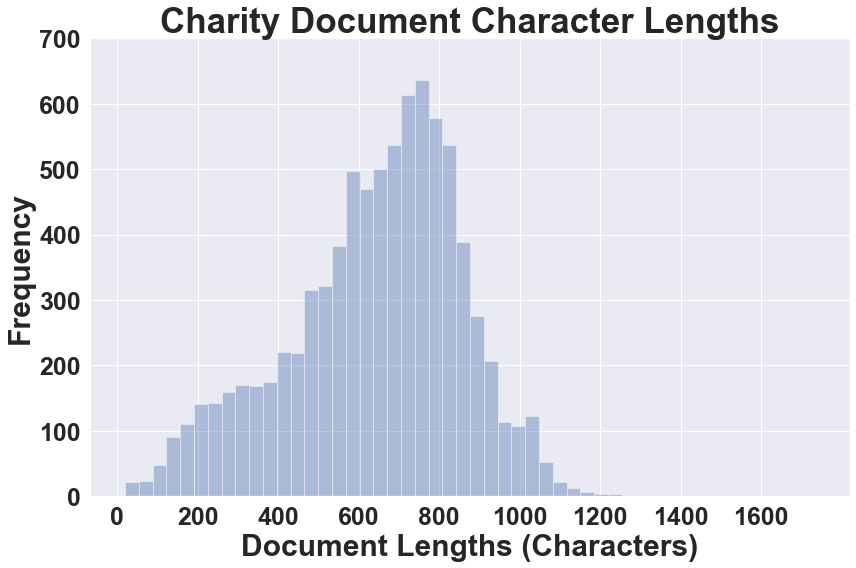

In [58]:
# Histogram of Charity Document Charity Lengths
fig, ax = plt.subplots(figsize=(12,8))

ax = sns.distplot(char_corp_lengths,color = 'b',kde=False,hist=True,norm_hist=False)

# Title
ax.set_title(label="Charity Document Character Lengths",weight='bold',fontsize=35)

# X-axis
x_tick_nums = np.arange(0,1601,200)
ax.set_xticks(x_tick_nums)
ax.set_xticklabels(labels=x_tick_nums,weight='bold',fontsize=25)
ax.set_xlabel(xlabel="Document Lengths (Characters)",weight='bold',fontsize=30)

# Y-axis
y_tick_nums = np.arange(0,701,100)
ax.set_yticks(y_tick_nums)
ax.set_yticklabels(labels=y_tick_nums,weight='bold',fontsize=25)
ax.set_ylabel(ylabel="Frequency",weight='bold',fontsize=30)

plt.tight_layout()

# plt.savefig('CharityDescCharacterLengths.png')

In [10]:
# There are 11 Categories Total
## A "Random Guess" Baseline is 1/11 = 9.09%

## Modeling

## Evaluating Model on Same Category Accuracy

In [94]:
find_similar_charities_category_score(charity_navigator_df,charity_navigator_df,"description")

1. Processing Training Corpus
2. Creating Index from Training Corpus
3. Starting Test Corpus Similarity Analysis

Analyzed 500 documents...
Analyzed 1000 documents...
Analyzed 1500 documents...
Analyzed 2000 documents...
Analyzed 2500 documents...
Analyzed 3000 documents...
Analyzed 3500 documents...
Analyzed 4000 documents...
Analyzed 4500 documents...
Analyzed 5000 documents...
Analyzed 5500 documents...
Analyzed 6000 documents...
Analyzed 6500 documents...
Analyzed 7000 documents...
Analyzed 7500 documents...
Analyzed 8000 documents...

First Recommendation Score: 64.18 %
Second Recommendation Score: 62.65 %
Third Recommendation Score: 61.55 %

AVG Recommendation Score: 62.79 %


{4463: 0.34888342, 4566: 0.26108187, 5495: 0.23793216}

In [95]:
find_similar_charities_category_score(charity_navigator_df,charity_navigator_df,"corpus")

1. Processing Training Corpus
2. Creating Index from Training Corpus
3. Starting Test Corpus Similarity Analysis

Analyzed 500 documents...
Analyzed 1000 documents...
Analyzed 1500 documents...
Analyzed 2000 documents...
Analyzed 2500 documents...
Analyzed 3000 documents...
Analyzed 3500 documents...
Analyzed 4000 documents...
Analyzed 4500 documents...
Analyzed 5000 documents...
Analyzed 5500 documents...
Analyzed 6000 documents...
Analyzed 6500 documents...
Analyzed 7000 documents...
Analyzed 7500 documents...
Analyzed 8000 documents...

First Recommendation Score: 66.2 %
Second Recommendation Score: 63.59 %
Third Recommendation Score: 63.31 %

AVG Recommendation Score: 64.37 %


{4463: 0.276772, 4566: 0.21008909, 7388: 0.18323708}

In [96]:
find_similar_charities_category_score(charity_navigator_df,charity_navigator_df,"motto")

1. Processing Training Corpus
2. Creating Index from Training Corpus
3. Starting Test Corpus Similarity Analysis

Analyzed 500 documents...
Analyzed 1000 documents...
Analyzed 1500 documents...
Analyzed 2000 documents...
Analyzed 2500 documents...
Analyzed 3000 documents...
Analyzed 3500 documents...
Analyzed 4000 documents...
Analyzed 4500 documents...
Analyzed 5000 documents...
Analyzed 5500 documents...
Analyzed 6000 documents...
Analyzed 6500 documents...
Analyzed 7000 documents...
Analyzed 7500 documents...
Analyzed 8000 documents...

First Recommendation Score: 40.02 %
Second Recommendation Score: 34.17 %
Third Recommendation Score: 34.63 %

AVG Recommendation Score: 36.27 %


{5666: 0.7845843, 5880: 0.74907124, 3050: 0.65272915}

In [108]:
category_dict = dict()
category_dict['description'] = 62.79
category_dict['corpus'] = 64.37
category_dict['motto'] = 36.27
for key,val in category_dict.items():
    print(key, val)

description 62.79
corpus 64.37
motto 36.27


## Evaluating Model on Similarity Score Accuracy

In [87]:
find_similar_charities_similar_score(charity_navigator_df,charity_navigator_df,"description")

1. Processing Training Corpus
2. Creating Index from Training Corpus
3. Starting Test Corpus Similarity Analysis

Analyzed 500 documents...
Analyzed 1000 documents...
Analyzed 1500 documents...
Analyzed 2000 documents...
Analyzed 2500 documents...
Analyzed 3000 documents...
Analyzed 3500 documents...
Analyzed 4000 documents...
Analyzed 4500 documents...
Analyzed 5000 documents...
Analyzed 5500 documents...
Analyzed 6000 documents...
Analyzed 6500 documents...
Analyzed 7000 documents...
Analyzed 7500 documents...
Analyzed 8000 documents...

First Recommendation Score: 27.81 %
Second Recommendation Score: 24.0 %
Third Recommendation Score: 22.09 %

AVG Recommendation Score: 24.63 %


{4463: 0.34888342, 4566: 0.26108187, 5495: 0.23793216}

In [117]:
# Word Needs to Be in at least 4 documents:
find_similar_charities_similar_score(charity_navigator_df,charity_navigator_df,"corpus")

1. Processing Training Corpus
2. Creating Index from Training Corpus
3. Starting Test Corpus Similarity Analysis

Analyzed 500 documents...
Analyzed 1000 documents...
Analyzed 1500 documents...
Analyzed 2000 documents...
Analyzed 2500 documents...
Analyzed 3000 documents...
Analyzed 3500 documents...
Analyzed 4000 documents...
Analyzed 4500 documents...
Analyzed 5000 documents...
Analyzed 5500 documents...
Analyzed 6000 documents...
Analyzed 6500 documents...
Analyzed 7000 documents...
Analyzed 7500 documents...
Analyzed 8000 documents...

First Recommendation Score: 30.4 %
Second Recommendation Score: 26.53 %
Third Recommendation Score: 24.52 %

AVG Recommendation Score: 27.15 %


{4463: 0.276772, 4566: 0.2360477, 7388: 0.18839781}

In [89]:
find_similar_charities_similar_score(charity_navigator_df,charity_navigator_df,"motto")

1. Processing Training Corpus
2. Creating Index from Training Corpus
3. Starting Test Corpus Similarity Analysis

Analyzed 500 documents...
Analyzed 1000 documents...
Analyzed 1500 documents...
Analyzed 2000 documents...
Analyzed 2500 documents...
Analyzed 3000 documents...
Analyzed 3500 documents...
Analyzed 4000 documents...
Analyzed 4500 documents...
Analyzed 5000 documents...
Analyzed 5500 documents...
Analyzed 6000 documents...
Analyzed 6500 documents...
Analyzed 7000 documents...
Analyzed 7500 documents...
Analyzed 8000 documents...

First Recommendation Score: 49.13 %
Second Recommendation Score: 44.25 %
Third Recommendation Score: 40.96 %

AVG Recommendation Score: 44.78 %


{5666: 0.7845843, 5880: 0.74907124, 3050: 0.65272915}

In [109]:
similar_dict = dict()
similar_dict['description'] = 24.63
similar_dict['corpus'] = 25.72
similar_dict['motto'] = 44.78
for key,val in similar_dict.items():
    print(key, val)

description 24.63
corpus 25.72
motto 44.78


In [170]:
find_similar_charities_from_search(charity_navigator_df,"This thing about fantastic 4 was super exciting")

1. Processing Training Corpus
2. Creating Model from Training Corpus
ValuesView(<gensim.corpora.dictionary.Dictionary object at 0x1a2c231c50>)
3. Starting Test Corpus Similarity Analysis


First Recommendation Score: 21.27 %
Second Recommendation Score: 15.5 %
Third Recommendation Score: 14.48 %

AVG Recommendation Score: 17.08 %


{7243: 0.21273313, 1557: 0.15501666, 7368: 0.14479208}

In [208]:
texts = [['human', 'interface', 'computer', 'determine']]
dct = Dictionary(texts)

In [209]:
dct

In [210]:
dict_list = []
for i in range(len(dct)):
    dict_list.append(dct[i])
dict_list = np.array(dict_list)

In [211]:
dict_list

array(['computer', 'determine', 'human', 'interface'], dtype='<U9')

In [212]:
text2

'Here we lie on the edge of the world, and try to determine if the existence of life is futile already'

In [213]:
text1

'Some text to analyze similarity for and determine if there is any cosine similarity to documents already in the database'

In [215]:
dctx = create_sim_word_dict(text1, text2, dct)

In [217]:
dctx

{'determine': 1}

In [220]:
for i in sorted (dctx) : 
    print (i,":", dctx[i])

determine : 1


In [221]:
text1 = 'The mission of the National Veterans Foundation (NVF) is to serve the crisis management, information and referral needs of all U.S. Veterans and their families through: Management and operation of the nations only toll-free helpline for all veterans and their families. Public awareness programs that shine a consistent spotlight on the needs of Americas veterans. NVF offers outreach services that provide veterans and families in need with food, clothing, transportation, employment, and other essential resources. The founder of the National Veterans Foundation, Floyd Shad Meshad has been working with Veterans since 1970. Meshad was a Medical Service Officer during the Vietnam War, where he counseled soldiers in the field who were suffering from a multitude of psychological and emotional problems resulting from their experiences in combat, including what would later become known as Post Traumatic Stress Disorder, or PTSD.'

In [224]:
text1.lower().split()

['the',
 'mission',
 'of',
 'the',
 'national',
 'veterans',
 'foundation',
 '(nvf)',
 'is',
 'to',
 'serve',
 'the',
 'crisis',
 'management,',
 'information',
 'and',
 'referral',
 'needs',
 'of',
 'all',
 'u.s.',
 'veterans',
 'and',
 'their',
 'families',
 'through:',
 'management',
 'and',
 'operation',
 'of',
 'the',
 'nations',
 'only',
 'toll-free',
 'helpline',
 'for',
 'all',
 'veterans',
 'and',
 'their',
 'families.',
 'public',
 'awareness',
 'programs',
 'that',
 'shine',
 'a',
 'consistent',
 'spotlight',
 'on',
 'the',
 'needs',
 'of',
 'americas',
 'veterans.',
 'nvf',
 'offers',
 'outreach',
 'services',
 'that',
 'provide',
 'veterans',
 'and',
 'families',
 'in',
 'need',
 'with',
 'food,',
 'clothing,',
 'transportation,',
 'employment,',
 'and',
 'other',
 'essential',
 'resources.',
 'the',
 'founder',
 'of',
 'the',
 'national',
 'veterans',
 'foundation,',
 'floyd',
 'shad',
 'meshad',
 'has',
 'been',
 'working',
 'with',
 'veterans',
 'since',
 '1970.',
 'mes

In [235]:
t1 = charity_navigator_df.corpus[1]

In [234]:
t2 = charity_navigator_df.corpus[3]

In [236]:
dctx = create_sim_word_dict(text1, text2, dct)

In [237]:
dctx

{}